In [2019]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import shift
from scipy.ndimage import zoom
from skimage import transform

In [2020]:
ss = 9

In [2199]:
tpf = np.zeros((1000,11*ss,11*ss))

fwhm = 2.3*ss
x0 = 5.4*ss
y0 = 5.8*ss

rshift_x = np.random.normal(0, 0.05, 1000)
rshift_y = np.random.normal(0, 0.05, 1000)

for x in range(11*ss):
    for y in range(11*ss):
        tpf[:,x,y] += 200*np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)


for i in range(1000):
    tpf[i] = shift(tpf[i], [-0.1 + 1.7*i/len(tpf)/2.0+rshift_x[i], -0.5 + 2.5*i/len(tpf)/2.0+rshift_y[i]], output=None, order=1, mode='constant', cval=0.0, prefilter=False)

    
    
#for i in range(1000):
#    val = 200.0*i/len(tpf)
#    tpf[i,4,4:7] -= val
#    tpf[i,7,4:7] += val

norm_super_tpf = tpf[400]

tpf_out = np.zeros((1000,11,11))
for i in range(1000):
    tpf_out[i] = np.sum(tpf[i].reshape(11, ss, 11, ss), axis=(1,3))
    
tpf = tpf_out + 0.0

x0 = np.array([1.0*i/len(tpf)*ss/2.0 for i in range(1000)])
y0 = np.array([2.5*i/len(tpf)*ss/2.0 for i in range(1000)])

print(y0)

[  0.        0.01125   0.0225    0.03375   0.045     0.05625   0.0675
   0.07875   0.09      0.10125   0.1125    0.12375   0.135     0.14625
   0.1575    0.16875   0.18      0.19125   0.2025    0.21375   0.225
   0.23625   0.2475    0.25875   0.27      0.28125   0.2925    0.30375
   0.315     0.32625   0.3375    0.34875   0.36      0.37125   0.3825
   0.39375   0.405     0.41625   0.4275    0.43875   0.45      0.46125
   0.4725    0.48375   0.495     0.50625   0.5175    0.52875   0.54
   0.55125   0.5625    0.57375   0.585     0.59625   0.6075    0.61875
   0.63      0.64125   0.6525    0.66375   0.675     0.68625   0.6975
   0.70875   0.72      0.73125   0.7425    0.75375   0.765     0.77625
   0.7875    0.79875   0.81      0.82125   0.8325    0.84375   0.855
   0.86625   0.8775    0.88875   0.9       0.91125   0.9225    0.93375
   0.945     0.95625   0.9675    0.97875   0.99      1.00125   1.0125
   1.02375   1.035     1.04625   1.0575    1.06875   1.08      1.09125
   1.1025    1.11

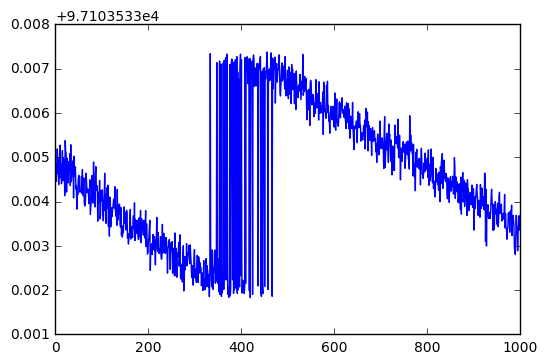

In [2200]:
plt.plot(np.sum(tpf, axis=(1,2)))

In [2201]:
lc = np.sum(tpf, axis=(1,2))
yc = np.linspace(0, 1, 1000)
xc = np.linspace(-0.5, 2.2, 1000)

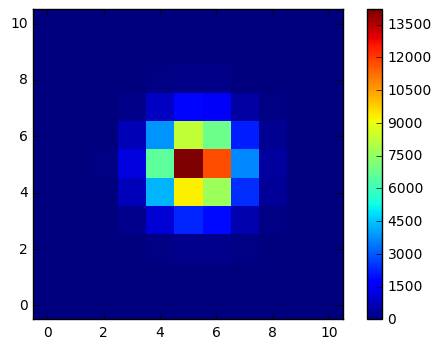

In [2202]:
plt.imshow(tpf[1], origin='lower', interpolation='nearest')
plt.colorbar()

In [2203]:
from scipy.interpolate import RectBivariateSpline

In [2204]:
x = np.linspace(0, 10, 11)
y = np.linspace(0, 10, 11)

xp = np.linspace(0, 10, 11*ss)
yp = np.linspace(0, 10, 11*ss)

In [2205]:
#tpf = np.log(tpf)

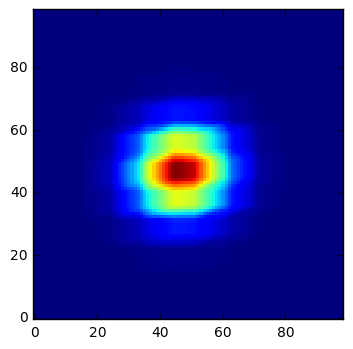

In [2206]:
super_tpf = [transform.resize(tpf[i], np.asarray(tpf[i].shape)*ss, order=0) for i in range(1000)]
super_tpf = [shift(super_tpf[i], [-x0[i], -y0[i]], output=None, order=1, mode='constant', cval=0.0, prefilter=False)
             for i in range(1000)]


mean_super_tpf = np.mean(super_tpf, axis=0)
mean_super_tpf[mean_super_tpf < 0] = 0.0
norm_super_tpf = mean_super_tpf / np.sum(mean_super_tpf)

plt.imshow(norm_super_tpf, origin='lower', interpolation='nearest')

In [2207]:
detector = np.ones((11*ss,11*ss))

In [2208]:
def model_prime(f, dy, dx, template):
    interp_again = RectBivariateSpline(xp, yp, template, kx=1, ky=1)
    return f * interp_again(yp - dy, xp - dx)
    #interp_again = shift(template, [dy, dx], output=None, order=1, mode='constant', cval=0.0, prefilter=False)
    #return f * interp_again

In [2209]:
def model(f, dy, dx, template):
    tmp = model_prime(f, dy, dx, template).reshape(11, ss, 11, ss)
    return np.sum(tmp, axis=(1, 3))


In [2210]:
data = tpf[0]

In [2211]:
class lnlikelihood:
    def __init__(self, data):
        self.data = data
        
    def evaluate(self, p, template_s, template_d):
        f, dy, dx = p
        r = model(f, dy, dx, template_s)*model(1, 0, 0, template_d) - self.data
        return np.sum(r * r)

In [2212]:
from scipy.optimize import minimize
from tqdm import tqdm

print(np.shape(norm_super_tpf))

(99, 99)


In [2213]:
results = []
lnlike = []
for i in tqdm(range(1000)):
    logL = lnlikelihood(data=tpf[i])
    sol = minimize(logL.evaluate, x0=(195, 0.001*i, 0.002*i), args=(norm_super_tpf, detector), method='Powell')
    #print(sol.fun)
    results.append(sol.x)
    lnlike.append(sol.fun)
    #print(lnlike)

100%|██████████| 1000/1000 [02:02<00:00,  9.05it/s]


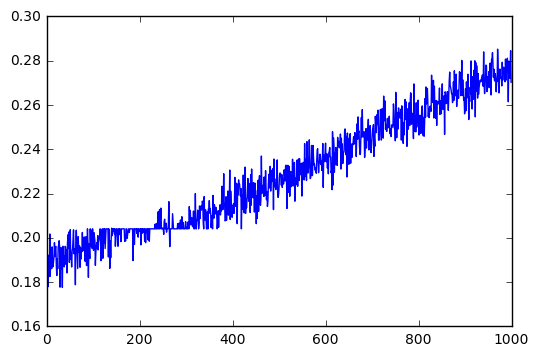

In [2215]:
results = np.array(results)
plt.plot(results[:,1])

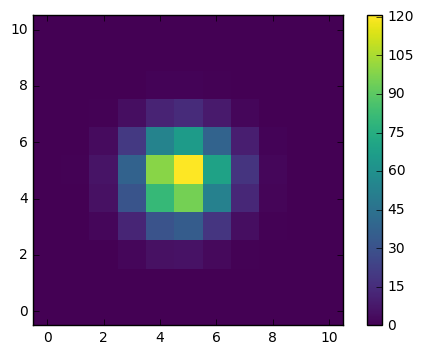

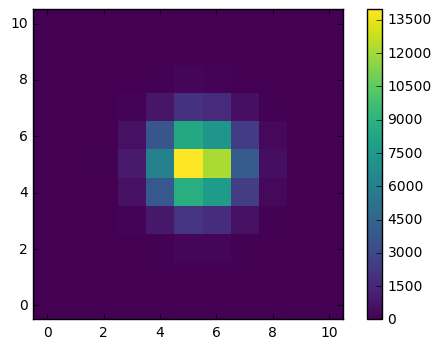

[  1.08350598e+00   6.59371788e+02   2.90402701e+83              inf
              inf              inf              inf              inf
   6.42203438e+74   2.73341662e+02   1.06947372e+00]
[  6.88224285e-03   2.24689088e-01   3.03401434e+00   1.84621170e+01
   5.29745098e+01   6.93158624e+01   3.85626704e+01   8.60239435e+00
   7.39890145e-01   2.39005986e-02   2.62736680e-04]
[  4.40416064e-10   6.17748481e-10   8.09016564e-10   1.01456949e-09
   1.23455065e-09   1.47114549e-09   1.91537690e-09   6.78700205e-09
   1.37800060e-08   2.11765969e-08   2.90033823e-08   3.73574559e-08
   4.62460139e-08   5.56656529e-08   6.56682639e-08   7.94322322e-08
   1.65396183e-07   2.82728264e-07   4.02636428e-07   5.27413429e-07
   6.59116867e-07   7.97723413e-07   9.43058925e-07   1.09547674e-06
   1.27314065e-06   1.85233414e-06   2.56827119e-06   3.25319556e-06
   3.94757784e-06   4.67137778e-06   5.42361631e-06   6.20281678e-06
   7.00945536e-06   7.87163096e-06   9.32618881e-06   1.07876801e-

/Users/ozymandias1/anaconda2/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: overflow encountered in exp


In [2216]:
model_ = model(1000, 0.0, 0.0, norm_super_tpf)
#model_test = model(np.sum(tpf[-1]), results[-1][1], results[-1][2], norm_super_tpf)
plt.imshow(model_, origin='lower', interpolation='nearest', cmap='viridis')
plt.colorbar()
plt.show()
#plt.imshow(mode, origin='lower', interpolation='nearest', cmap='viridis')
#plt.show()
plt.imshow(tpf[400], origin='lower', interpolation='nearest', cmap='viridis')
plt.colorbar()
plt.show()

print(np.exp(tpf[400,:,5]))
print(model_[:,6])
print(norm_super_tpf[17])


In [2217]:
logL = lnlikelihood(data=tpf[400])
print(logL.evaluate((45.67, 1.6, 0.0), norm_super_tpf, detector))

695636265.331


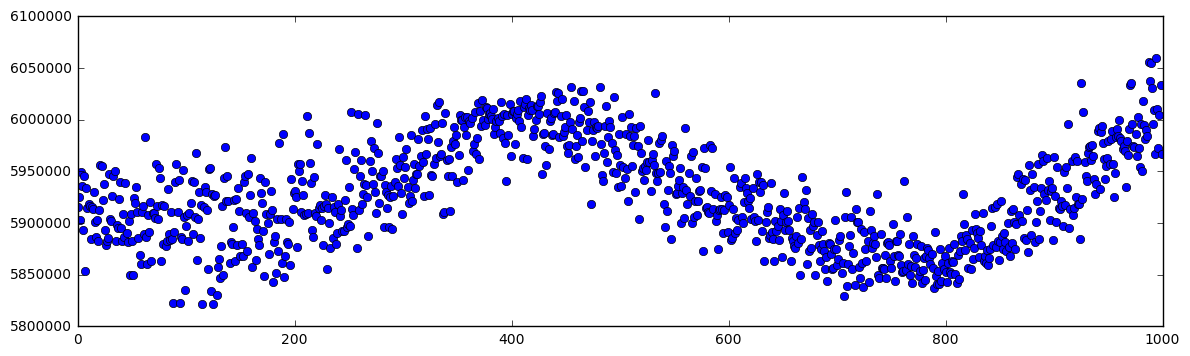

In [2218]:
plt.figure(figsize=[14, 4])
plt.plot(np.arange(1000), lnlike, 'o')

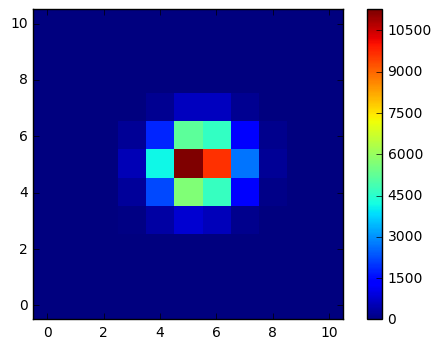

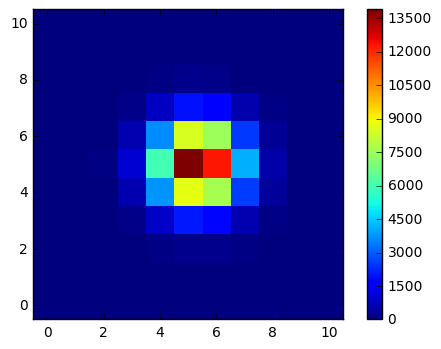

60192.7783991
97103.5396099
[  1.30113529e+03   2.23068756e-01   5.75791376e-01]


In [2219]:
gds = norm_super_tpf
i = 500
plt.imshow(models[i], interpolation='nearest', origin='lower')
plt.colorbar()
plt.show()
plt.imshow(tpf[i], interpolation='nearest', origin='lower')
plt.colorbar()
plt.show()
print(np.sum(models[i]))
print(np.sum(tpf[i]))
print(results[500])

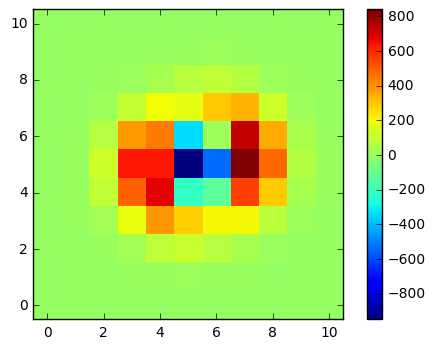

In [2220]:
models = [ss*ss*model(*results[i], norm_super_tpf) for i in range(1000)]

i = 500
plt.imshow(models[i] - tpf[i], interpolation='nearest', origin='lower')
plt.colorbar()
#interps = [RectBivariateSpline(x, y, models[i]*16 - tpf[i], kx=1, ky=1) for i in range(1000)]

resids = models - tpf

interps = [transform.resize(resids[i], np.asarray(resids[i].shape)*ss, order=0) for i in range(1000)]
interps = [shift(interps[i], [1.0*ss*results[i,1], 1.0*ss*results[i][2]], output=None, order=1, mode='constant', cval=0.0, prefilter=False)
             for i in range(1000)]


In [2221]:
detector = np.ones((11*ss,11*ss))

In [2222]:
dlnlike_ds = 2 * interps

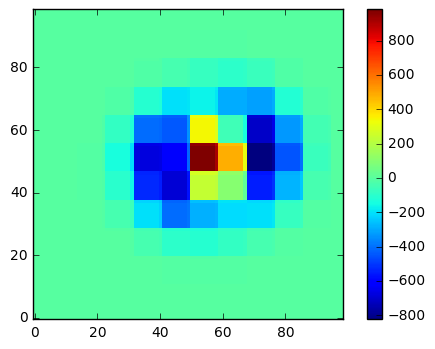

In [2223]:
plt.imshow(-dlnlike_ds[350], origin='lower', interpolation='nearest')
plt.colorbar()

In [2224]:
dlnlike_ds = np.sum(dlnlike_ds, axis=0)

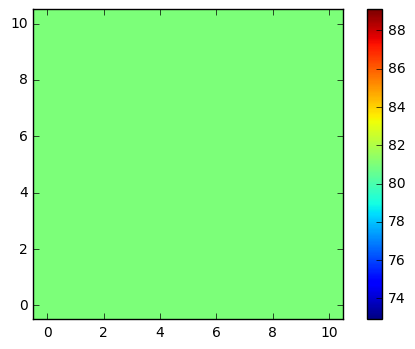

In [2225]:
plt.imshow(model(1, 0, 0, detector), origin='lower', interpolation='nearest')
plt.colorbar()

In [2226]:
#gds = np.copy(norm_super_tpf)

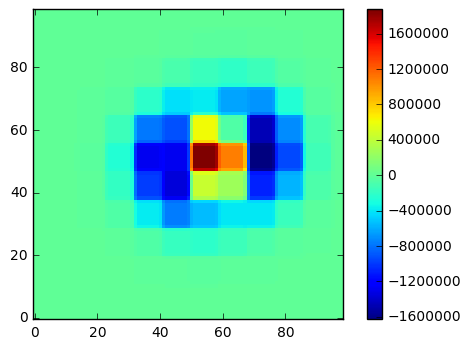

In [2227]:
plt.imshow(-dlnlike_ds, origin='lower', interpolation='nearest')
plt.colorbar()

In [2228]:
def gradient_descent_ds(template_s, template_d, p):
    f_n, yc_n, xc_n = p
    j = 0
    c = 1e-10
    tmp_s = template_s
    models = [model(f_n[i], yc_n[i], xc_n[i], tmp_s)*model(1, 0, 0, template_d) for i in range(1000)]
    
    
    resids = models - tpf
    interps = [transform.resize(resids[i], np.asarray(resids[i].shape)*ss, order=0) for i in range(1000)]
    interps = [shift(interps[i], [-1.0*ss*yc_n[i], -1.0*ss*xc_n[i]], output=None, order=1, mode='constant', cval=0.0, prefilter=False)
             for i in range(1000)]

    dlnlike_ds = 2 * interps
    dlnlike_ds = np.sum(dlnlike_ds, axis=0)
    plt.imshow(-dlnlike_ds, interpolation='nearest', origin='lower')
    plt.colorbar()
    plt.show()
    logL_before = np.sum([lnlikelihood(data=tpf[i]).evaluate((f_n[i], yc_n[i], xc_n[i]), tmp_s, template_d)
                          for i in range(1000)])
    while j < 50:
        tmp_s = tmp_s - c * dlnlike_ds
        tmp_s[tmp_s < 0] = 0.0
        logL_after = np.sum([lnlikelihood(data=tpf[i]).evaluate((f_n[i], yc_n[i], xc_n[i]), tmp_s, template_d)
                             for i in range(1000)])
        print(logL_before)
        print(logL_after, c, j)
        if logL_after < logL_before:
            c *= 1.6
            models = [model(f_n[i], yc_n[i], xc_n[i], tmp_s)*model(1, 0, 0, template_d) for i in range(1000)]
            resids = models - tpf
            interps = [transform.resize(resids[i], np.asarray(resids[i].shape)*ss, order=0) for i in range(1000)]
            interps = [shift(interps[i], [-1.0*ss*yc_n[i], -1.0*ss*xc_n[i]], output=None, order=1, mode='constant', cval=0.0, prefilter=False)
             for i in range(1000)]
            dlnlike_ds = 2 * interps
            dlnlike_ds = np.sum(dlnlike_ds, axis=0)
        else:
            c *= -0.2
        if np.abs(c) < 1e-16:
            break
        if np.abs(logL_after - logL_before)/ logL_after < 1e-7:
            break
        logL_before = logL_after
        j += 1
    return tmp_s

In [2229]:
def gradient_descent_dd(template_s, template_d, p):
    f_n, yc_n, xc_n = p
    j = 0
    c = 1e-10
    tmp_d = template_d
    models = [model(f_n[i], yc_n[i], xc_n[i], template_s)*model(1, 0, 0, tmp_d) for i in range(1000)]
    resids = models - tpf
    interps = [transform.resize(resids[i], np.asarray(resids[i].shape)*ss, order=0) for i in range(1000)]
    
    dlnlike_dd = 2 * interps
    dlnlike_dd = np.sum(dlnlike_dd, axis=0)
    logL_before = np.sum([lnlikelihood(data=tpf[i]).evaluate((f_n[i], yc_n[i], xc_n[i]), template_s, tmp_d)
                              for i in range(1000)])
    while j < 2000:
        tmp_d = tmp_d - c * dlnlike_dd
        logL_after = np.sum([lnlikelihood(data=tpf[i]).evaluate((f_n[i], yc_n[i], xc_n[i]), template_s, tmp_d)
                             for i in range(1000)])
        print(logL_before)
        print(logL_after)
        if logL_after < logL_before:
            c *= 1.1
            models = [model(f_n[i], yc_n[i], xc_n[i], template_s)*model(1, 0, 0, tmp_d) for i in range(1000)]
            resids = models - tpf
            interps = [transform.resize(resids[i], np.asarray(resids[i].shape)*ss, order=0) for i in range(1000)]

            dlnlike_dd = 2 * interps
            dlnlike_dd = np.sum(dlnlike_dd, axis=0)
        else:
            c *= .25
        if c < 1e-14:
            break
        logL_before = logL_after
        j += 1
    return tmp_d

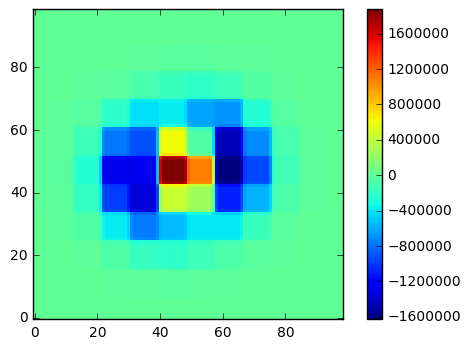

5927721818.87
1757069613.45 1e-10 0
1757069613.45
4137880822.76 1.6000000000000002e-10 1
4137880822.76
1876721167.42 -3.2000000000000006e-11 2
1876721167.42
6166665901.32 -5.1200000000000014e-11 3
6166665901.32
5108569332.0 1.0240000000000003e-11 4
5108569332.0
2790648707.61 1.6384000000000005e-11 5
2790648707.61
957395741.065 2.621440000000001e-11 6
957395741.065
126054571.768 4.1943040000000016e-11 7
126054571.768
23017217.6132 6.710886400000003e-11 8
23017217.6132
21455050.6144 1.0737418240000005e-10 9
21455050.6144
21440607.0356 1.717986918400001e-10 10
21440607.0356
38237498.2761 2.748779069440002e-10 11
38237498.2761
29391027.0361 -5.497558138880004e-11 12
29391027.0361
86894395.305 -8.796093022208007e-11 13
86894395.305
71536043.0949 1.7592186044416015e-11 14
71536043.0949
33508710.8014 2.8147497671065624e-11 15
33508710.8014
19111038.7248 4.5035996273705e-11 16
19111038.7248
17776580.7313 7.2057594037928e-11 17
17776580.7313
17143112.1975 1.1529215046068481e-10 18
17143112.1975

In [2230]:
results = np.array(results)
gds = gradient_descent_ds(norm_super_tpf, detector, (results[:, 0], results[:,1], results[:, 2]))


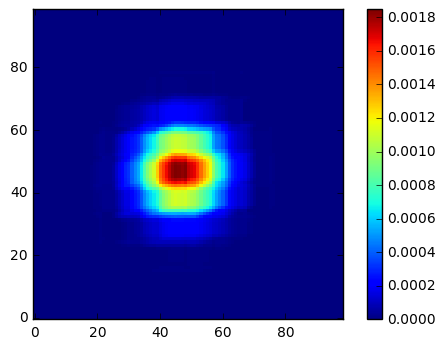

In [2231]:
plt.imshow(gds, origin='lower', interpolation='nearest')
plt.colorbar()

In [2232]:
f_n, yc_n, xc_n = results[:, 0], results[:, 1], results[:, 2]

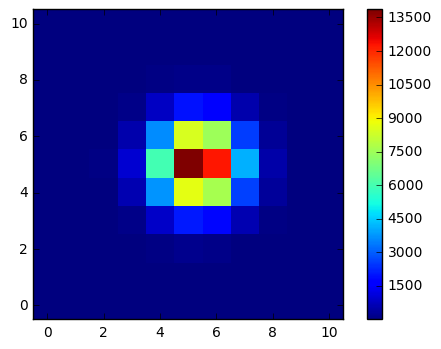

In [2233]:
n=500
plt.imshow(model(f_n[n], yc_n[n], xc_n[n], gds) * model(1, 0, 0, detector) + 1, origin='lower', interpolation='nearest')
plt.colorbar()

In [2234]:
results = []
lnlike = []
for i in tqdm(range(1000)):
    logL = lnlikelihood(data=tpf[i])
    sol = minimize(logL.evaluate, x0=(f_n[i], yc_n[i], xc_n[i]), args=(gds, detector), method='Powell')
    results.append(sol.x)
    lnlike.append(sol.fun)

100%|██████████| 1000/1000 [01:52<00:00,  9.89it/s]


In [2235]:
pred_flux = [np.sum(model(f_n[i], yc_n[i], xc_n[i], gds)*ss*ss) for i in range(1000)] 

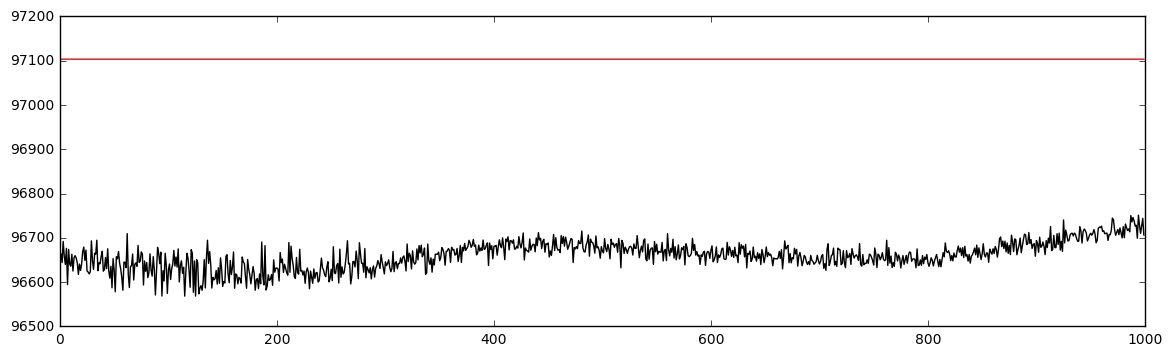

In [2236]:
plt.figure(figsize=[14, 4])
plt.plot(np.arange(1000), pred_flux, 'k')
plt.plot(np.arange(1000), np.sum(tpf, axis=(1,2)), 'r')
#plt.ylim(1500, 2500)

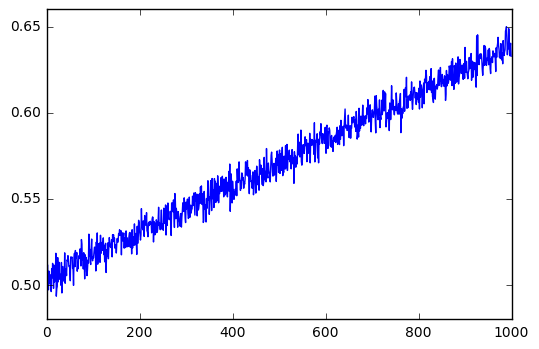

In [2237]:
results = np.array(results)
plt.plot(np.arange(1000), results[:,2])

1920.9999975547826

What have we learned? This works *perfectly* when the star is not moving. This is a good thing!
When the star is moving, this is not working perfectly. Need to trace down why and figure out how to stop it.

0


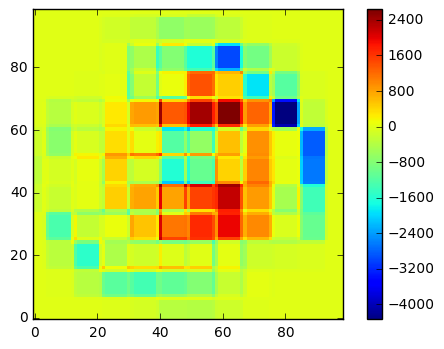

1018687.48288
1004264.78851 1e-10 0
1004264.78851
1004334.80876 1.6000000000000002e-10 1
1004334.80876
1013497.45619 -3.2000000000000006e-11 2
1013497.45619
1011104.31147 6.400000000000002e-12 3
1011104.31147
1003314.74097 1.0240000000000003e-11 4
1003314.74097
996936.235146 1.6384000000000005e-11 5
996936.235146
994744.713518 2.621440000000001e-11 6
994744.713518
992736.275453 4.1943040000000016e-11 7
992736.275453
990395.599118 6.710886400000003e-11 8
990395.599118
986832.288262 1.0737418240000005e-10 9
986832.288262
981327.804859 1.717986918400001e-10 10
981327.804859
972970.06371 2.748779069440002e-10 11
972970.06371
961014.849117 4.3980465111040033e-10 12


In [ ]:
for j in range(100):
    print(j)
    
    results = np.array(results)
    gds = gradient_descent_ds(gds, detector, (results[:, 0], results[:,1], results[:, 2]))
    
    plt.imshow(gds, origin='lower', interpolation='nearest')
    plt.colorbar()
    plt.show()

    f_n, yc_n, xc_n = results[:, 0], results[:, 1], results[:, 2]
    
    results = []
    lnlike = []
    for i in tqdm(range(1000)):
        logL = lnlikelihood(data=tpf[i])
        sol = minimize(logL.evaluate, x0=(f_n[i], yc_n[i], xc_n[i]), args=(gds, detector), method='Powell')
        results.append(sol.x)
        lnlike.append(sol.fun)
    


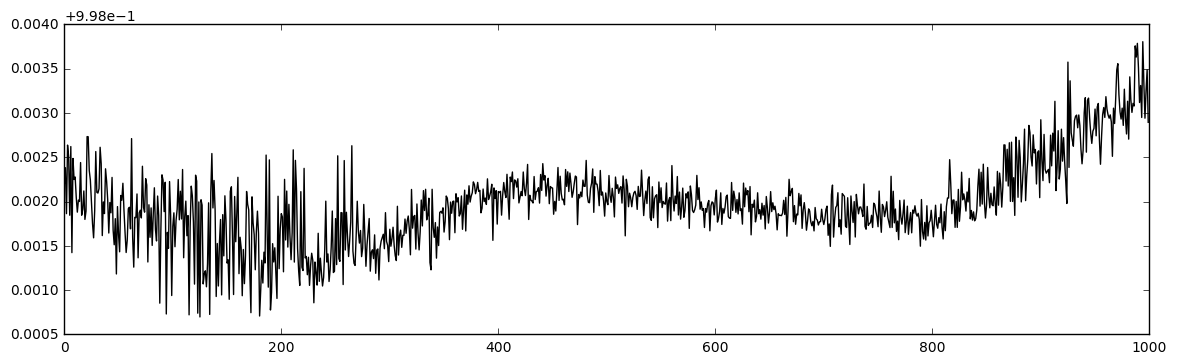

In [2239]:
pred_flux = [np.sum(model(f_n[i], yc_n[i], xc_n[i], gds)*ss*ss) for i in range(1000)] 

plt.figure(figsize=[14, 4])
plt.plot(np.arange(1000), pred_flux/np.sum(tpf, axis=(1,2)), 'k')
#plt.plot(np.arange(1000), np.sum(tpf, axis=(1,2)), 'r')
#plt.ylim(1690, 1900)

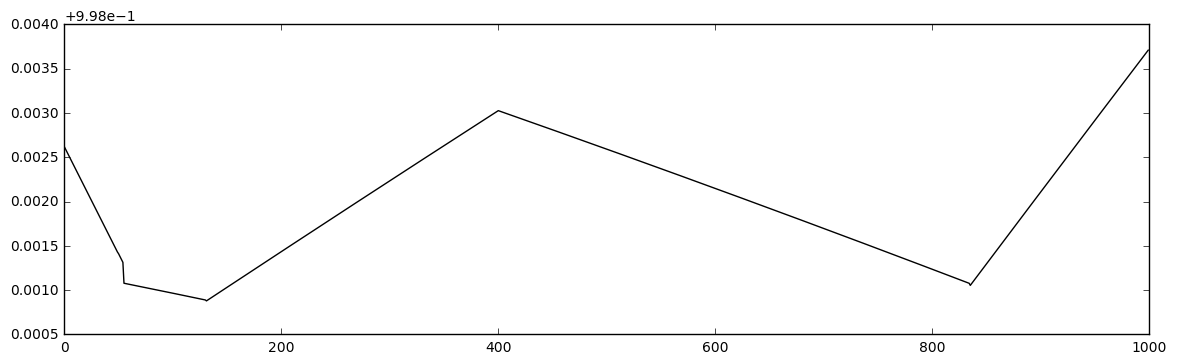

In [2182]:
pred_flux = [np.sum(model(f_n[i], yc_n[i], xc_n[i], gds)*ss*ss) for i in range(1000)] 

plt.figure(figsize=[14, 4])
plt.plot(np.arange(1000), pred_flux/np.sum(tpf, axis=(1,2)), 'k')
#plt.plot(np.arange(1000), np.sum(tpf, axis=(1,2)), 'r')
#plt.ylim(1690, 1900)

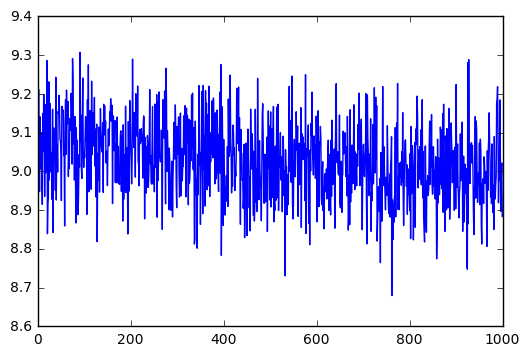

In [2246]:
plt.plot(xc_n*ss*2.0-np.linspace(0, 2.5, 1000))